# GaussianCopula Model

In this guide we will go through a series of steps that will let you discover
functionalities of the `GaussianCopula` model, including how to:

* Create an instance of a `GaussianCopula`.
* Fit the instance to your data.
* Generate synthetic versions of your data.
* Use the a `GaussianCopula` to anonymize PII information.
* Customize the data tranformations to improve the learning process.
* Specify the column distributions to improve the output quality.

## What is GaussianCopula?

The `sdv.tabular.GaussianCopula` model from `SDV` is based on the
`copulas.multivariate.GaussianMultivariate` class from the [Copulas library](
https://sdv.dev/Copulas), a library for modeling and sampling multivariate distributions
based on [copula funtions](https://en.wikipedia.org/wiki/Copula_%28probability_theory%29).

In mathematical terms, a Gaussian Copula is a distribution over the unit cube
${\displaystyle [0,1]^{d}}$ which is constructed from a multivariate normal distribution over
${\displaystyle \mathbb {R} ^{d}}$ by using the probability integral transform. Intuitively,
a Copula is a mathematical function that allows us to describe the joint distribution of
multiple random variables by analyzing the dependencies between their marginal distributions.

Let's now discover how to learn a dataset and later on generate synthetic data with the same
format and statistical properties by using the `GaussianCopula` model.

## Quick Usage

We will start by loading one of our demo datasets, the `student_placements`, which contains information
about MBA students that applied for placements during the year 2020.

In [1]:
# Setup logging and warnings - change ERROR to INFO for increased verbosity
import logging
logging.basicConfig(level=logging.ERROR)

logging.getLogger().setLevel(level=logging.ERROR)
logging.getLogger('sdv').setLevel(level=logging.ERROR)

import warnings
warnings.simplefilter("ignore")

In [2]:
from sdv.demo import load_tabular_demo

data = load_tabular_demo('student_placements')
data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0


As you can see, this table contains information about students which includes, among other things:

- Their id and gender
- Their grades and specializations
- Their work experience
- The salary that they where offered
- The duration and dates of their placement

You will notice that there is data with the following characteristics:

- There are float, integer, boolean, categorical and datetime values.
- There are some variables that have missing data. In particular, all the data related to the
  placement details is missing in the rows where the studen was not placed.

Let us use the `GaussianCopula` to learn this data and then sample synthetic data about new students
to see how well de model captures the characteristics indicated above. In order to do this you wil
need to:

- Import the `sdv.tabular.GaussianCopula` class and create an instance of it.
- Call its `fit` method passing our table.
- Call its `sample` method indicating the number of synthetic rows that you want to generate.

In [3]:
from sdv.tabular import GaussianCopula

model = GaussianCopula()
model.fit(data)

<div class="alert alert-info">

**NOTE**

Notice that the model `fitting` process took care of transforming the different fields using the
appropriate [Reversible Data Transforms](http://github.com/sdv-dev/RDT) to ensure that the data has
a format that the GaussianMultivariate model from the [copulas](https://github.com/sdv-dev/Copulas)
library can handle.

</div>

### Generate synthetic data from the model

Once the modeling has finished you are ready to generate new synthetic data by calling the `sample` method
from your model passing the number of rows that we want to generate.

In [4]:
new_data = model.sample(200)

This will return a table identical to the one which the model was fitted on, but filled with new data
which resembles the original one.

In [5]:
new_data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17282,F,82.918676,80.355269,Commerce,65.757095,Comm&Mgmt,False,1,61.013293,Mkt&HR,65.816117,26355.404673,True,2020-03-23,2020-10-18,3.0
1,17343,F,64.535047,52.634040,Commerce,71.070744,Comm&Mgmt,False,1,58.889472,Mkt&Fin,63.474707,27024.442621,True,2020-01-07,2020-02-29,3.0
2,17324,F,58.206966,69.091563,Commerce,63.894046,Comm&Mgmt,False,-1,59.774227,Mkt&HR,63.663878,NaN,False,NaT,NaT,3.0
3,17443,F,65.155290,59.601842,Science,56.941617,Comm&Mgmt,False,1,50.187125,Mkt&HR,66.148182,NaN,False,NaT,NaT,NaN
4,17388,F,83.459734,116.066140,Commerce,77.697360,Comm&Mgmt,False,1,95.425914,Mkt&HR,73.717939,31432.659861,True,2020-02-27,2020-08-17,3.0


<div class="alert alert-info">

**Note**

You can control the number of rows by specifying the number of `samples` in the
`model.sample(<num_rows>)`. To test, try `model.sample(10000)`. Note that the original 
table only had ~200 rows.

</div>

### Save and Load the model

In many scenarios it will be convenient to generate synthetic versions of your data
directly in systems that do not have access to the original data source. For example,
if you may want to generate testing data on the fly inside a testing environment that
does not have access to your production database. In these scenarios, fitting the
model with real data every time that you need to generate new data is feasible, so you
will need to fit a model in your production environment, save the fitted model into a
file, send this file to the testing environment and then load it there to be able to
`sample` from it.

Let's see how this process works.

#### Save and share the model

Once you have fitted the model, all you need to do is call its `save` method passing the
name of the file in which you want to save the model. Note that the extension of the filename
is not relevant, but we will be using the `.pkl` extension to highlight that the serialization
protocol used is [pickle](https://docs.python.org/3/library/pickle.html).

In [6]:
model.save('my_model.pkl')

This will have created a file called `my_model.pkl` in the same directory in which you are
running SDV.

<div class="alert alert-info">

**IMPORTANT**
    
If you inspect the generated file you will notice that its size is much smaller
than the size of the data that you used to generate it. This is because the serialized model
contains **no information about the original data**, other than the parameters it needs to
generate synthetic versions of it. This means that you can safely share this `my_model.pkl`
file without the risc of disclosing any of your real data!
    
</div>

#### Load the model and generate new data

The file you just generated can be send over to the system where the synthetic data will be
generated. Once it is there, you can load it using the `GaussianCopula.load` method, and
then you are ready to sample new data from the loaded instance:

In [7]:
loaded = GaussianCopula.load('my_model.pkl')
new_data = loaded.sample(200)

<div class="alert alert-warning">
    
**WARNING**
    
Notice that the system where the model is loaded needs to also have `sdv` installed,
otherwise it will not be able to load the model and use it.
    
</div>

### Specifying the Primary Key of the table

One of the first things that you may have noticed when looking that demo data
is that there is a `student_id` column which acts as the primary key of the table,
and which is supposed to have unique values. Indeed, if we look at the number of
times that each value appears, we see that all of them appear at most once:

In [8]:
data.student_id.value_counts().max()

1

However, if we look at the synthetic data that we generated, we observe that there
are some values that appear more than once:

In [9]:
new_data.student_id.value_counts().max()

5

In [10]:
new_data[new_data.student_id == new_data.student_id.value_counts().index[0]]

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
8,17394,F,56.261563,46.538582,Science,67.101888,Sci&Tech,False,0,67.731701,Mkt&Fin,61.941818,26002.881305,True,2020-03-05,2020-12-01,NaN
61,17394,F,77.671217,52.503500,Science,65.630896,Comm&Mgmt,False,1,78.854266,Mkt&Fin,59.915104,33179.439114,True,2020-01-10,2020-06-13,3.0
74,17394,M,62.112794,67.256705,Commerce,70.976886,Comm&Mgmt,False,0,74.082681,Mkt&Fin,69.185283,27891.194165,True,2020-03-25,2020-07-23,3.0
128,17394,M,52.841502,58.404632,Commerce,62.156629,Comm&Mgmt,False,1,62.572893,Mkt&HR,56.127287,NaN,False,NaT,NaT,NaN
189,17394,M,45.731866,58.173755,Commerce,52.699592,Comm&Mgmt,False,1,71.344712,Mkt&HR,53.659953,NaN,False,NaT,NaT,NaN


This happens because the model was not notified at any point about the fact that the
`student_id` had to be unique, so when it generates new data it will provoke collisions
sooner or later. In order to solve this, we can pass the argument `primary_key` to our
model when we create it, indicating the name of the column that is the index of the table.

In [11]:
model = GaussianCopula(
    primary_key='student_id'
)
model.fit(data)
new_data = model.sample(200)

As a result, the model will learn that this column must be unique and generate a unique
sequence of valures for the column:

In [12]:
new_data.head()

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,M,59.990072,67.842457,Commerce,64.413529,Comm&Mgmt,False,1,81.941199,Mkt&Fin,60.012519,NaN,False,NaT,NaT,12.0
1,1,M,61.554330,67.829679,Commerce,71.843651,Sci&Tech,False,0,70.947288,Mkt&Fin,56.835192,29582.500193,True,2020-01-10,2020-11-21,12.0
2,2,M,62.413395,62.268670,Commerce,65.740773,Comm&Mgmt,False,0,61.004692,Mkt&Fin,53.851748,22740.227765,True,2020-03-02,2020-06-10,3.0
3,3,M,74.421217,70.239090,Commerce,72.627976,Comm&Mgmt,False,0,72.446205,Mkt&HR,62.776679,21189.913909,True,2020-02-22,2020-10-29,3.0
4,4,F,70.004719,68.847607,Commerce,67.483150,Comm&Mgmt,False,-1,71.215792,Mkt&HR,70.974736,35255.177928,True,2020-04-01,2020-12-20,NaN


In [13]:
new_data.student_id.value_counts().max()

1

### Anonymizing Personally Identifiable Information (PII) 

There will be many cases where the data will contain Personally Identifiable Information
which we cannot disclose. In these cases, we will want our Tabular Models to replace the
information within these fields with fake, simulated data that looks similar to the real
one but does not contain any of the original values.

Let's load a new dataset that contains a PII field, the `student_placements_pii` demo, and
try to generate synthetic versions of it that do not contain any of the PII fields.

<div class="alert alert-info">
    
**NOTE**
    
The `student_placements_pii` dataset is a modified version of the `student_placements`
dataset with one new field, `address`, which contains PII information about the students.
Notice that this additional `address` field has been simulated and does not correspond to data
from the real users.

</div>

In [14]:
data_pii = load_tabular_demo('student_placements_pii')

In [15]:
data_pii.head().T

,0,1,2,3,4
student_id,17264,17265,17266,17267,17268
address,"70304 Baker Turnpike\nEricborough, MS 15086","805 Herrera Avenue Apt. 134\nMaryview, NJ 36510","3702 Bradley Island\nNorth Victor, FL 12268",Unit 0879 Box 3878\nDPO AP 42663,"96493 Kelly Canyon Apt. 145\nEast Steven, NC 3..."
gender,M,M,M,M,M
second_perc,67,79.33,65,56,85.8
high_perc,91,78.33,68,52,73.6
high_spec,Commerce,Science,Arts,Science,Commerce
degree_perc,58,77.48,64,52,73.3
degree_type,Sci&Tech,Sci&Tech,Comm&Mgmt,Sci&Tech,Comm&Mgmt
work_experience,False,True,False,False,False
experience_years,0,1,0,0,0


If we use our tabular model on this new data we will see how the synthetic
data that it generates discloses the addresses from the real students:

In [16]:
model = GaussianCopula(
    primary_key='student_id',
)
model.fit(data_pii)

In [17]:
new_data_pii = model.sample(200)
new_data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,"73000 Wood Underpass\nPort Donald, UT 60180",M,63.752723,67.680361,Commerce,72.272666,Sci&Tech,False,1,55.084581,Mkt&HR,60.430306,23307.232873,True,2020-02-05,2021-01-01,12.0
1,1,"9647 Martin Divide\nNorth William, NY 73345",M,54.632591,71.276281,Commerce,67.607087,Comm&Mgmt,False,1,53.994266,Mkt&HR,63.106473,37559.177906,True,2020-01-13,2020-12-13,12.0
2,2,Unit 9984 Box 1462\nDPO AA 02334,M,75.172660,71.618016,Science,79.945676,Comm&Mgmt,False,1,55.141539,Mkt&Fin,66.974940,33874.839812,True,2020-01-22,2020-10-01,12.0
3,3,"241 Golden Drive\nChristinafurt, NJ 40726",M,61.686783,56.526398,Science,68.855419,Sci&Tech,False,0,66.633810,Mkt&Fin,61.713204,NaN,False,NaT,NaT,NaN
4,4,"79045 Mary Prairie\nEast Christina, GA 42034",F,70.969859,54.017094,Science,64.326371,Sci&Tech,False,0,66.637541,Mkt&HR,65.100091,NaN,False,NaT,NaT,NaN


In [18]:
new_data_pii.address.isin(data_pii.address).sum()

200

In order to solve this, we can pass an additional argument `anonymize_fields` to
our model when we create the instance. This `anonymize_fields` argument will need
to be a dictionary that contains:

- The name of the field that we want to anonymize.
- The category of the field that we want to use when we generate fake values for it.

The list complete list of possible categories can be seen in the [Faker Providers
](https://faker.readthedocs.io/en/master/providers.html) page, and it contains a huge
list of concepts such as:

- name
- address
- country
- city
- ssn
- credit_card_number
- credit_card_expier
- credit_card_security_code
- email
- telephone
- ...

In this case, since the field is an e-mail address, we will pass a dictionary indicating
the category `address`

In [19]:
model = GaussianCopula(
    primary_key='student_id',
    anonymize_fields={
        'address': 'address'
    }
)
model.fit(data_pii)

As a result, we can see how the real `address` values have been replaced by other fake
addresses that were not taken from the real data that we learned.

In [20]:
new_data_pii = model.sample(200)
new_data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,63168 Kelly Roads Suite 423\nSouth Samuelburgh...,M,57.859965,56.792523,Science,69.620761,Sci&Tech,False,1,63.731746,Mkt&Fin,57.880941,27151.870786,True,2020-02-07,2020-11-08,12.0
1,1,"01275 Morgan Squares Suite 515\nJacobchester, ...",M,63.278166,47.378445,Science,62.675544,Comm&Mgmt,False,0,68.145926,Mkt&HR,62.363655,NaN,False,NaT,NaT,NaN
2,2,"6929 Cruz Mission Apt. 803\nSabrinaport, IL 59337",F,68.025376,59.368326,Commerce,71.182536,Sci&Tech,False,0,50.521372,Mkt&HR,57.902559,NaN,False,NaT,NaT,3.0
3,3,"2532 Natasha Hollow\nLake Heatherport, NE 11745",F,46.007111,62.086452,Commerce,65.501302,Comm&Mgmt,False,0,81.123876,Mkt&Fin,63.975630,NaN,False,NaT,NaT,NaN
4,4,"368 Kristin Path\nHansenton, VA 01169",M,71.850262,64.472910,Science,72.971129,Sci&Tech,False,2,54.391814,Mkt&Fin,66.076633,NaN,False,NaT,NaT,NaN


In [21]:
new_data_pii.address.isin(data_pii.address).sum()

0

## Advanced Usage

Now that we have discovered the basics, let's go over a few more advanced usage examples
and see the different arguments that we can pass to our `GaussianCopula` Model in order to
customize it to our needs.

### How to set transforms to use?

One thing that you may have noticed when executing the previous steps is that the fitting
process took much longer on the `student_placements_pii` dataset than it took on the
previous version that did not contain the sudent `address`. This happens because the
`address` field is interpreted as a categorical variable, which the `GaussianCopula`
[one-hot encoded](https://en.wikipedia.org/wiki/One-hot) generating 215 new columns that
it had to learn afterwards.

This transformation, which in this case was very inefficient, happens because the Tabular
Models apply [Reversible Data Transforms](https://github.com/sdv-dev/RDT) under the hood
to transform all the non-numerical variables, which the underlying models cannot handle,
into numerical representations which they can properly work with. In the case of the
`GaussianCopula`, the default transformation is a One-Hot encoding, which can work very
well with variables that have a little number of different values, but which is very
inefficient in cases where there is a large number of values.

For this reason, the Tabular Models have an additional argument called `field_transformers`
that let you select which transformer to apply to each column. This `field_transformers`
argument must be passed as a `dict` which contains the name of the fields for which
we want to use a transformer different than the default, and the name of the transformer
that we want to use.

Possible transformer names are:

* `integer`: Uses a `NumericalTransformer` of dtype `int`.
* `float`: Uses a `NumericalTransformer` of dtype `float`.
* `categorical`: Uses a `CategoricalTransformer` without gaussian noise.
* `categorical_fuzzy`: Uses a `CategoricalTransformer` adding gaussian noise.
* `one_hot_encoding`: Uses a `OneHotEncodingTransformer`.
* `label_encoding`: Uses a `LabelEncodingTransformer`.
* `boolean`: Uses a `BooleanTransformer`.
* `datetime`: Uses a `DatetimeTransformer`.

**NOTE**: For additional details about each one of the transformers, please visit [RDT](
https://github.com/sdv-dev/RDT)

Let's now try to improve the previous fitting process by changing the transformer
that we use for the `address` field to something other than the default. As an example,
we will use the `label_encoding` transformer, which instead of generating one column for
each possible value, it just replaces each value with a unique integer value.

In [22]:
model = GaussianCopula(
    primary_key='student_id',
    anonymize_fields={
        'address': 'address'
    },
    field_transformers={
        'address': 'label_encoding'
    }
)
model.fit(data_pii)

In [23]:
new_data_pii = model.sample(200)
new_data_pii.head()

,student_id,address,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,0,"41999 Roger Ramp Suite 133\nJohnchester, IL 82301",M,75.146865,74.653554,Commerce,74.225868,Others,False,1,72.411819,Mkt&HR,64.344925,26357.372180,True,2020-07-22,2021-02-10,3.0
1,1,"6993 Latasha Alley\nPort Melissa, MD 23546",F,62.343484,53.209265,Science,54.550109,Sci&Tech,False,0,83.987053,Mkt&HR,52.954313,29503.977328,True,2020-02-16,2020-06-27,3.0
2,2,"77442 Reed Knoll Apt. 636\nMccarthyberg, MA 58702",F,71.488736,68.261721,Commerce,68.582396,Comm&Mgmt,False,0,55.636144,Mkt&Fin,64.312930,21363.743520,True,2020-01-03,2020-07-30,12.0
3,3,"499 Phillips Burgs Suite 208\nEast Joshua, LA ...",M,70.040363,60.020577,Science,63.449994,Sci&Tech,False,1,55.351452,Mkt&HR,56.050120,24238.648699,True,2020-01-29,2020-07-03,3.0
4,4,USNS West\nFPO AE 71584,M,74.529375,71.153957,Arts,69.995287,Comm&Mgmt,False,0,73.869570,Mkt&HR,56.468982,27600.078186,True,2020-01-03,2020-06-24,3.0


### Exploring the Probability Distributions

During the previous steps, every time we fitted the `GaussianCopula` it performed
the following operations:

1. Learn the format and data types of the passed data
2. Transform the non-numerical and null data using [Reversible Data Transforms](
   https://github.com/sdv-dev/RDT) to obtain a fully numerical representation of
   the data from which we can learn the probability distributions.
3. Learn the probability distribution of each column from the table
4. Learn the correlation between the marginal probabilities using a Gaussian Copula.

After this, when we used the model to generate new data for our table using the `sample`
method, it did:

5. Sample from a Multivariate Standard Normal distribution with the learned correlations.
6. Reverse the sampled probabilities using the marginal distributions.
7. Reverse the RDT transformations to go back to the original data format.

As you can see, during these steps the _Marginal Probability Distributions_ have a very important
role, since the `GaussianCopula` had to learn and reproduce the individual distributions of each
column in our table. We can explore the distributions which the `GaussianCopula` used to model each
column using its `get_distributions` method:

In [24]:
model = GaussianCopula(
    primary_key='student_id'
)
model.fit(data)

distributions = model.get_distributions()

This will return us a `dict` which contains the name of the distribution
class used for each column:

In [25]:
distributions

{'gender#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'gender#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'second_perc': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'high_perc': 'copulas.univariate.log_laplace.LogLaplace',
 'high_spec#0': 'copulas.univariate.gaussian.GaussianUnivariate',
 'high_spec#1': 'copulas.univariate.gamma.GammaUnivariate',
 'high_spec#2': 'copulas.univariate.gaussian.GaussianUnivariate',
 'degree_perc': 'copulas.univariate.student_t.StudentTUnivariate',
 'degree_type#0': 'copulas.univariate.student_t.StudentTUnivariate',
 'degree_type#1': 'copulas.univariate.gaussian.GaussianUnivariate',
 'degree_type#2': 'copulas.univariate.gaussian.GaussianUnivariate',
 'work_experience': 'copulas.univariate.student_t.StudentTUnivariate',
 'experience_years': 'copulas.univariate.gaussian.GaussianUnivariate',
 'employability_perc': 'copulas.univariate.truncated_gaussian.TruncatedGaussian',
 'mba_spec#0': 'copulas.univariate.gamma.GammaUnivar

<div class="alert alert-info">

**NOTE**

In this list we will see multiple distributions for each one of the columns
that we have in our data. This is because the RDT transformations used
to encode the data numerically often use more than one column to represent
each one of the input variables.

</div>

Let's explore the individual distribution of one of the columns in our data to better
understand how the `GaussianCopula` processed them and see if we can improve the results
by manually specifying a different distribution. For example, let's explore the
`experience_years` column by looking at the frequency of its values within the original data:

In [26]:
data.experience_years.value_counts()

0    141
1     65
2      8
3      1
Name: experience_years, dtype: int64

And plotting it using the `copulas.visualization` functions:

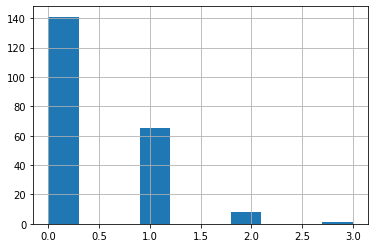

In [27]:
data.experience_years.hist();

By observing the data we can see that the behavior of the values in this column is very
similar to a Gamma or even some types of Beta distribution, where the majority of the
values are 0 and the frequency decreases as the values increase.

Was the `GaussianCopula` able to capture this distribution on its own?

In [28]:
distributions['experience_years']

'copulas.univariate.gaussian.GaussianUnivariate'

It seems that the it was not, as it rather thought that the behavior was closer to a
Gaussian distribution. And, as a result, we can see how the generated values now contain
negative values which are invalid for this column:

In [29]:
new_data.experience_years.value_counts()

 0    115
 1     68
-1     14
 2      3
Name: experience_years, dtype: int64

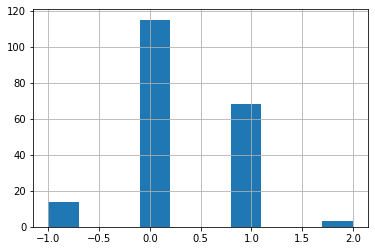

In [30]:
new_data.experience_years.hist();

Let's see how we can improve this situation by passing the `GaussianCopula`
the exact distribution that we want it to use for this column.

### Setting distributions for indvidual variables 

The `GaussianCopula` class offers the possibility to indicate which distribution to use
for each one of the columns in the table, in order to solve situations like the one
that we just described. In order to do this, we need to pass a `field_distributions` argument
with `dict` that indicates the distribution that we want to use for each column.

Possible values for the distribution argument are:

* `univariate`: Let `copulas` select the optimal univariate distribution.
  This may result in non-parametric models being used.
* `parametric`: Let `copulas` select the optimal univariate distribution,
  but restrict the selection to parametric distributions only.
* `bounded`: Let `copulas` select the optimal univariate distribution,
  but restrict the selection to bounded distributions only.
  This may result in non-parametric models being used.
* `semi_bounded`: Let `copulas` select the optimal univariate distribution,
  but restrict the selection to semi-bounded distributions only.
  This may result in non-parametric models being used.
* `parametric_bounded`: Let `copulas` select the optimal univariate
  distribution, but restrict the selection to parametric and bounded distributions
  only.
* `parametric_semi_bounded`: Let `copulas` select the optimal univariate
  distribution, but restrict the selection to parametric and semi-bounded
  distributions only.
* `gaussian`: Use a Gaussian distribution.
* `gamma`: Use a Gamma distribution.
* `beta`: Use a Beta distribution.
* `student_t`: Use a Student T distribution.
* `gussian_kde`: Use a GaussianKDE distribution. This model is non-parametric,
  so using this will make `get_parameters` unusable.
* `truncated_gaussian`: Use a Truncated Gaussian distribution.

Let's see what happens if we make the `GaussianCopula` use the `gamma` distribution
for our column.

In [31]:
from sdv.tabular import GaussianCopula

model = GaussianCopula(
    primary_key='student_id',
    field_distributions={
        'experience_years': 'gamma'
    }
)
model.fit(data)

After this, we can see how the `GaussianCopula` used the indicated distribution
for the `experience_years` column

In [32]:
model.get_distributions()['experience_years']

'copulas.univariate.gamma.GammaUnivariate'

And, as a result, now we can see how the generated data now have a behavior which is
closer to the original data and always stays within the valid values range.

In [33]:
new_data = model.sample(len(data))

In [34]:
new_data.experience_years.value_counts()

0    195
1     17
2      2
3      1
Name: experience_years, dtype: int64

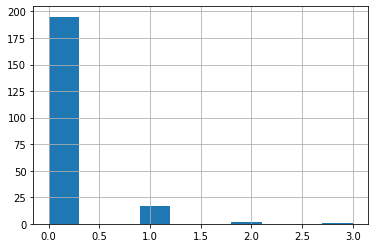

In [35]:
new_data.experience_years.hist();

<div class="alert alert-info">
    
**NOTE**
    
Even though there are situations like the one show above where manually choosing
a distribution seems to give better results, in most cases the `GaussianCopula`
will be able to find the optimal distribution on its own, making this manual
search of the marginal distributions necessary on very little occasions.

</div>

### How do I specify constraints?

If you look closely at the data you may notice that some properties were
not completely captured by the model. For example, you may have seen
that sometimes the model produces an `experience_years` number greater
than `0` while also indicating that `work_experience` is `False`. These
type of properties are what we call `Constraints` and can also be
handled using `SDV`. For further details about them please visit the
[Handling Constraints](04_Handling_Constraints.ipynb) tutorial.

### Can I evaluate the Synthetic Data?

A very common question when someone starts using **SDV** to generate
synthetic data is: *\"How good is the data that I just generated?\"*

In order to answer this question, **SDV** has a collection of metrics
and tools that allow you to compare the *real* that you provided and the
*synthetic* data that you generated using **SDV** or any other tool.

You can read more about this in the [Evaluating Synthetic Data Generators](05_Evaluating_Synthetic_Data_Generators.ipynb) tutorial.